<a href="https://colab.research.google.com/github/abs-git/NLP/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Load data

In [3]:
# glue data load

path = '/content/gdrive/MyDrive/Colab Notebooks/NLP'

with open(path + '/glue_train.txt', 'r') as f:
  train_sentences = f.readlines()

for i, sen in enumerate(train_sentences):
  train_sentences[i] = sen.rstrip("\n")

with open(path + '/glue_test.txt', 'r') as f:
  test_sentences = f.readlines()

for i, sen in enumerate(test_sentences):
  test_sentences[i] = sen.rstrip("\n")

print("train : {}".format(len(train_sentences)))
print("test : {}".format(len(test_sentences)))

print(train_sentences[:2])
print(test_sentences[:2])


train : 8551
test : 1063
["Our friends won't buy this analysis, let alone the next one we propose.", "One more pseudo generalization and I'm giving up."]
['Bill whistled past the house.', 'The car honked its way down the road.']


# Create tokenizer

In [4]:
!pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from tokenizers import SentencePieceBPETokenizer

tokenizer = SentencePieceBPETokenizer()

train_path = path + '/glue_train.txt'

vocab_size = 32000
limit_alphabet = 5000

tokenizer.train(files = train_path,
                vocab_size = vocab_size,
                limit_alphabet = limit_alphabet,
                show_progress = True)


In [6]:
# test

output = tokenizer.encode(test_sentences[0])
decoded = tokenizer.decode(output.ids)

print(output.tokens)
print(output.ids)
print(output.offsets)
print(decoded)


['▁Bill', '▁whistled', '▁past', '▁the', '▁house', '.']
[197, 7963, 2495, 89, 746, 11]
[(0, 4), (4, 13), (13, 18), (18, 22), (22, 28), (28, 29)]
Bill whistled past the house.


# Common Module

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [8]:
# get inputs and zero-padding

inputs = []
for sen in train_sentences:
  pieces = tokenizer.encode(sen)
  inputs.append(torch.tensor(pieces.ids))

inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)

print(inputs.shape)
print(inputs[0].shape)
print(inputs[0])


torch.Size([8551, 49])
torch.Size([49])
tensor([2389, 1210,  996,  666,  333, 7471,  562, 3491,   89, 2078,  533,  262,
        1480, 1185,   11,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])


## Embedding

In [9]:
# input embedding

vocab_size = tokenizer.get_vocab_size()
hidden_size = 256

input_embedding_table = nn.Embedding(vocab_size, hidden_size)

input_embedding = input_embedding_table(inputs)

print(input_embedding.size())

torch.Size([8551, 49, 256])


In [10]:
# position embedding (sinusoid encoding, 정현파)

import numpy as np

def get_position_embedding(seq_size, hidden_size):

    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / hidden_size)
  
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(hidden_size)]

    pos_embedding = np.array([get_posi_angle_vec(i_seq) for i_seq in range(seq_size)])
    pos_embedding[:, 0::2] = np.sin(pos_embedding[:, 0::2])                       # even index sin 
    pos_embedding[:, 1::2] = np.cos(pos_embedding[:, 1::2])                       # odd index cos

    return torch.from_numpy(pos_embedding).type(torch.FloatTensor)


torch.Size([300, 256])


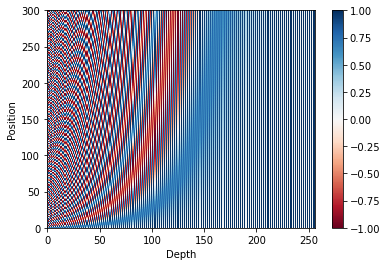

In [11]:
import matplotlib.pyplot as plt

seq_size = 300

pos_embedding = get_position_embedding(seq_size, hidden_size)
print(pos_embedding.shape)

plt.pcolormesh(pos_embedding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, hidden_size))
plt.ylabel('Position')
plt.colorbar()
plt.show()



In [12]:
pos_embedding_table = nn.Embedding.from_pretrained(pos_embedding, freeze = True)

print(pos_embedding_table)

# print(inputs)
print(inputs.size())

positions = torch.arange(inputs.size(1)).expand(inputs.size(0), inputs.size(1)).contiguous() + 1

# print(positions)
print(positions.shape)

print(inputs.eq(0).shape)

positions.masked_fill_(inputs.eq(0), 0)

# print(positions)
print(positions.shape)

position_embedding = pos_embedding_table(positions)

# print(position_embedding[0])
print(position_embedding.size())


Embedding(300, 256)
torch.Size([8551, 49])
torch.Size([8551, 49])
torch.Size([8551, 49])
torch.Size([8551, 49])
torch.Size([8551, 49, 256])


In [13]:
print(input_embedding.shape)
print(position_embedding.shape)

inputs_for_transformer = input_embedding + position_embedding

print(inputs_for_transformer.shape)

torch.Size([8551, 49, 256])
torch.Size([8551, 49, 256])
torch.Size([8551, 49, 256])


## Scaled Dot Product Attention


In [14]:
# input values (Query, Value, Key, Attention mask)
# Query = Value = Key = Set of the Sentence


def get_attention_mask(inputs):

  attention_mask = inputs.eq(0)       # padding (0) position
  # print(attention_mask.shape)

  attention_mask = inputs.eq(0).unsqueeze(1)
  # print(attention_mask.shape)

  attention_mask = inputs.eq(0).unsqueeze(1).expand(inputs.size(0), inputs.size(1), inputs.size(1))
  # print(attention_mask.shape)
  # print(attention_mask[0])

  return attention_mask


Q = inputs_for_transformer
K = inputs_for_transformer
V = inputs_for_transformer

attention_mask = get_attention_mask(inputs)


In [15]:
# self attention (Q = K = V)

class ScaledDotProductAttention(nn.Module):
  def __init__(self, head_dim):
    super().__init__()
    self.scale = 1 / np.sqrt(head_dim)

  def forward(self, Q, K, V, attention_mask):
    # print(Q.shape)
    # print(K.shape)
    # print(K.transpose(-1,-2).shape)
    # print()

    attention_scores = torch.matmul(Q, K.transpose(-1,-2))      # (batch_size, Q_size, K_size) / 단어 간 가중치 테이블
    # print(attention_scores.shape)

    attention_scores.mul_(self.scale)                         # (batch_size, Q_size, K_size)
    # print(attention_scores.shape)

    attention_scores.masked_fill_(attention_mask, -1e9)       # 0 -> -1e9
    # print(attention_scores.shape)
    # print(attention_scores[0])

    attention_probs = nn.Softmax(dim=-1)(attention_scores)    # (batch_size, Q_size, V_dim)
    # print(attention_probs.shape)
    # print(attention_probs[0])

    context = torch.matmul(attention_probs, V)                # (batch_size, Q_size, V_dim)
    # print(context.shape)

    return context, attention_probs



In [16]:
head_dim = 8

attention = ScaledDotProductAttention(head_dim)

context, attention_probs = attention(Q, K, V, attention_mask)

print('context         : {}'.format(context.shape))
print('attention probs : {}'.format(attention_probs.shape))


context         : torch.Size([8551, 49, 256])
attention probs : torch.Size([8551, 49, 49])


## Multi-Head Attention

In [17]:
# Divide N-heads

class MultiHeadAttention(nn.Module):
  def __init__(self, hidden_size, n_heads, head_dim):
    super().__init__()

    self.hidden_size = hidden_size
    self.n_heads = n_heads
    self.head_dim = head_dim
    
    self.W_Q = nn.Linear(hidden_size, n_heads * head_dim)
    self.W_K = nn.Linear(hidden_size, n_heads * head_dim)
    self.W_V = nn.Linear(hidden_size, n_heads * head_dim)

    self.attention = ScaledDotProductAttention(head_dim)
    self.linear = nn.Linear(n_heads * head_dim, hidden_size)

  def forward(self, Q, K, V, attention_mask):
    # print(Q.shape)
    # print(K.shape)
    # print(V.shape)
    # print()

    batch_size = Q.size(0)

    Q_split = self.W_Q(Q)                                                       # (batch_size, Q_size, n_heads * head_dim)
    Q_split = Q_split.view(batch_size, -1, self.n_heads, self.head_dim)         # (batch_size, Q_size, n_heads, head_dim)
    Q_split = Q_split.transpose(1,2)                                            # (batch_size, n_heads, Q_size, head_dim)

    K_split = self.W_K(K).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1,2)     # (batch_size, n_heads, K_size, head_dim)
    V_split = self.W_V(V).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1,2)     # (bathc_size, n_heads, V_size, head_dim)

    # print(Q_split.shape)
    # print(K_split.shape)
    # print(V_split.shape)
    # print()

    attention_mask = attention_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)   # (batch_size, n_heads, Q_size, K_size)

    context, attention_probs = self.attention(Q_split, K_split, V_split, attention_mask)

    context = context.transpose(1,2).contiguous().view(batch_size, -1, self.n_heads * self.head_dim)

    output = self.linear(context)       # (batch_size, n_heads, Q_size)

    return output, attention_probs



In [18]:
hidden_size = 256    # 위와 동일
n_heads = 4
head_dim = 8

multi_head_attention = MultiHeadAttention(hidden_size, n_heads, head_dim)

context, attention_probs = multi_head_attention(Q, K, V, attention_mask)

print(context.shape)
print(attention_probs.shape)
print(attention_probs[0])



torch.Size([8551, 49, 256])
torch.Size([8551, 4, 49, 49])
tensor([[[0.0352, 0.0623, 0.0631,  ..., 0.0000, 0.0000, 0.0000],
         [0.0591, 0.0514, 0.0400,  ..., 0.0000, 0.0000, 0.0000],
         [0.0515, 0.0339, 0.0354,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0496, 0.0468, 0.0643,  ..., 0.0000, 0.0000, 0.0000],
         [0.0496, 0.0468, 0.0643,  ..., 0.0000, 0.0000, 0.0000],
         [0.0496, 0.0468, 0.0643,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0514, 0.0408, 0.0584,  ..., 0.0000, 0.0000, 0.0000],
         [0.0503, 0.0910, 0.0536,  ..., 0.0000, 0.0000, 0.0000],
         [0.0624, 0.0473, 0.0591,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0691, 0.0274, 0.0485,  ..., 0.0000, 0.0000, 0.0000],
         [0.0691, 0.0274, 0.0485,  ..., 0.0000, 0.0000, 0.0000],
         [0.0691, 0.0274, 0.0485,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.1281, 0.0736, 0.0670,  ..., 0.0000, 0.0000, 0.0000],
         [0.0885, 0.0827, 0.0440,  ..., 0.0000, 0.0000, 0.0000],


## Masked Multi-Head Attention

In [19]:
# masked multi-head attention for decoder of the tansformer

def get_attention_mask_for_decoder(inputs):
  # print(inputs.shape)

  decoder_mask = torch.ones_like(inputs)
  # print(decoder_mask.shape)

  decoder_mask = decoder_mask.unsqueeze(-1)
  decoder_mask=  decoder_mask.expand(inputs.size(0), inputs.size(1), inputs.size(1))
  # print(decoder_mask.shape)
  # print(decoder_mask[0])

  decoder_mask = decoder_mask.triu(diagonal = 1)    # 주 대각선 아래ㄹ 모두 0으로 치환 (상삼각행렬 생성)
  # print(decoder_mask.shape)
  # print(decoder_mask[0])

  return decoder_mask


In [19]:
Q = inputs_for_transformer
K = inputs_for_transformer
V = inputs_for_transformer

attention_mask = get_attention_mask(inputs)   # zero padding
print(attention_mask[0])
print()

attention_mask_for_decoder = get_attention_mask_for_decoder(inputs)   # triangular matrix
print(attention_mask_for_decoder[0])
print()

attention_mask_for_decoder = torch.gt((attention_mask + attention_mask_for_decoder), 0)
print(attention_mask_for_decoder[0])


torch.Size([8551, 49])
torch.Size([8551, 1, 49])
torch.Size([8551, 49, 49])
tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])
tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

tensor([[0, 1, 1,  ..., 1, 1, 1],
        [0, 0, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 1, 1],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0

## FeedForward layer

In [20]:
# linear -> max -> linear

class FeedForward(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()

    self.linear_1 = nn.Linear(in_features = hidden_size, out_features = hidden_size * 4)
    self.linear_2 = nn.Linear(in_features = hidden_size *4, out_features = hidden_size)
    self.activation = F.gelu

  def forward(self, inputs):

    # print(inputs.shape)

    output = self.linear_1(inputs)
    # print(output.shape)

    output = output.transpose(1,2)
    # print(output.shape)

    output = self.activation(output)
    # print(output.shape)

    output = self.linear_2(output.transpose(1,2))
    # print(output.shape)


    return output


In [21]:
hidden_size = 256

FF = FeedForward(hidden_size)

output = FF(context)

print()
print('input shape  : {}'.format(context.shape))
print('output shape : {}'.format(output.shape))



torch.Size([8551, 49, 256])
torch.Size([8551, 49, 1024])
torch.Size([8551, 1024, 49])
torch.Size([8551, 1024, 49])
torch.Size([8551, 49, 256])

input shape  : torch.Size([8551, 49, 256])
output shape : torch.Size([8551, 49, 256])


# Transformer

## Parameters

In [21]:
# parameters

inputs = inputs               # (8551, 49)
vocab_size = vocab_size
seq_size = 256

# Q = inputs_for_transformer          # Self attention을 사용할 예정이라 사실 의미가 없음.
# K = inputs_for_transformer
# V = inputs_for_transformer

# attention_mask = get_attention_mask(inputs)

# attention_mask_for_decoder = get_attention_mask_for_decoder(inputs)   # triangular matrix
# attention_mask_for_decoder = torch.gt((attention_mask + attention_mask_for_decoder), 0)

hidden_size = 256
n_heads = 2
head_dim = 4

norm_epsilon = 0.00001
n_layers = 4



## Encoder

In [22]:
class EncoderLayer(nn.Module):
  def __init__(self, hidden_size, n_heads, head_dim, epsilon):
    super().__init__()

    self.attention = MultiHeadAttention(hidden_size, n_heads, head_dim)
    self.norm_layer_1 = nn.LayerNorm(hidden_size, eps=epsilon)              # Add & Norm

    self.feed_forward = FeedForward(hidden_size)
    self.norm_layer_2 = nn.LayerNorm(hidden_size, eps=epsilon)              # Add & Norm

  def forward(self, encoder_inputs, attention_mask):

    Q = encoder_inputs
    V = encoder_inputs
    K = encoder_inputs

    encoder_attention_output, encoder_attention_probs = self.attention(Q, V, K, attention_mask)

    encoder_attention_output = self.norm_layer_1(encoder_inputs + encoder_attention_output)

    feed_forward_output = self.feed_forward(encoder_attention_output)

    feed_forward_output = self.norm_layer_2(feed_forward_output + encoder_attention_output)
 
    return feed_forward_output, encoder_attention_probs


In [ ]:
encoder_layers = EncoderLayer(hidden_size, n_heads, head_dim, norm_epsilon)

encoder_output, attention_probs = encoder_layers(inputs, attention_mask)

print()
print('encoder output  : {}'.format(encoder_output.shape))
print('attention probs : {}'.format(attention_probs.shape))


torch.Size([8551, 49, 256])
torch.Size([8551, 49, 256])
torch.Size([8551, 49, 256])

torch.Size([8551, 2, 49, 4])
torch.Size([8551, 2, 49, 4])
torch.Size([8551, 2, 49, 4])

torch.Size([8551, 49, 256])
torch.Size([8551, 49, 1024])
torch.Size([8551, 1024, 49])
torch.Size([8551, 1024, 49])
torch.Size([8551, 49, 256])


In [25]:
class Encoder(nn.Module):
  def __init__(self, hidden_size, n_heads, head_dim, norm_epsilon, voacb_size, seq_size, n_layers):
    super().__init__()

    self.input_embedding_table = nn.Embedding(vocab_size, hidden_size)

    pos_embedding_matrix = get_position_embedding(seq_size, hidden_size)
    self.pos_embedding_table = nn.Embedding.from_pretrained(pos_embedding_matrix, freeze = True)

    self.encoder_layers = nn.ModuleList()
    for _ in range(n_layers):
      encoder = EncoderLayer(hidden_size, n_heads, head_dim, norm_epsilon)
      self.encoder_layers.append(encoder)


  def forward(self, encoder_inputs):

    positions = torch.arange(encoder_inputs.size(1)).expand(encoder_inputs.size(0), encoder_inputs.size(1)).contiguous() + 1
    pos_mask = encoder_inputs.eq(0)
    positions.masked_fill_(pos_mask, 0)

    outputs = self.input_embedding_table(encoder_inputs) + self.pos_embedding_table(positions)

    attention_mask = get_attention_mask(encoder_inputs)

    attention_probs_list = []
    for encoder in self.encoder_layers:
      outputs, attention_probs = encoder(outputs, attention_mask)
      attention_probs_list.append(attention_probs)

    
    return outputs, attention_probs



In [ ]:

encoder = Encoder(hidden_size, n_heads, head_dim, norm_epsilon, vocab_size, seq_size, n_layers)

encoder_outputs, attention_probs = encoder(inputs)

print('encoder outputs : {}'.format(encoder_outputs))
print('attention probs : {}'.format(attention_probs))


torch.Size([256, 256])
torch.Size([8551, 49])
torch.Size([8551, 1, 49])
torch.Size([8551, 49, 49])
tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])


## Decoder

In [24]:
class DecoderLayer(nn.Module):
  def __init__(self, hidden_size, n_heads, head_dim, epsilon):
    super().__init__()

    self.attention = MultiHeadAttention(hidden_size, n_heads, head_dim)
    self.norm_layer_1 = nn.LayerNorm(hidden_size, eps=epsilon)              # Add & Norm

    self.masked_attention = MultiHeadAttention(hidden_size, n_heads, head_dim)
    self.norm_layer_2 = nn.LayerNorm(hidden_size, eps=epsilon)

    self.feed_forward = FeedForward(hidden_size)
    self.norm_layer_3 = nn.LayerNorm(hidden_size, eps=epsilon)


  def forward(self, decoder_inputs, encoder_outputs, attention_mask, attention_mask_for_decoder):

    Q = decoder_inputs,
    V = decoder_inputs,
    K = decoder_inputs

    attention_outputs, attention_probs = self.attention(Q, V, K, attention_mask)
    attention_outputs = self.norm_layer_1(decoder_inputs + attention_outputs)

    dec_enc_attention_outputs, dec_enc_attention_probs = self.masked_attention(attention_outputs, encoder_outputs, decoder_inputs, attention_mask_for_decoder)
    dec_enc_attention_outputs = self.norm_layer_2(attention_outputs + dec_enc_attention_outputs)

    feed_forward_output = self.feed_forward(dec_enc_attention_outputs)
    feed_forward_output = self.norm_layer_3(dec_enc_attention_outputs + feed_forward_output)

    return feed_forward_output, attention_outputs, dec_enc_attention_probs



In [ ]:
class Decoder(nn.Module):
  def __init__(self, hidden_size, n_heads, head_dim, norm_epsilon, voacb_size, seq_size, n_layers):
    super().__init__()

    self.input_embedding_table = nn.Embedding(vocab_size, hidden_size)

    pos_embedding_matrix = get_position_embedding(seq_size, hidden_size)
    self.pos_embedding_table = nn.Embedding.from_pretrained(pos_embedding_matrix, freeze = True)

    self.decoder_layers = nn.ModuleList()
    for _ in range(n_layers):
      decoder = DecoderLayer(hidden_size, n_heads, head_dim, norm_epsilon)
      self.decoder_layers.append(decoder)


  def forward(self, decoder_inputs, encoder_inputs, encoder_outputs):

    positions = torch.arange(decoder_inputs.size(1)).expand(decoder_inputs.size(0), decoder_inputs.size(1)).contiguous() + 1
    pos_mask = decoder_inputs.eq(0)
    positions.masked_fill_(pos_mask, 0)

    decoder_outputs = self.input_embedding_table(decoder_inputs) + self.pos_embedding_table(positions)

    attention_mask = get_attention_mask(decoder_inputs)              # zero padding
    attention_mask_for_decoder = get_attention_mask_for_decoder(decoder_inputs)   # triangular matrix
    
    attention_mask_for_decoder = torch.gt((attention_mask + attention_mask_for_decoder), 0)

    dec_enc_attention_mask = get_attention_mask(decoder_inputs, encoder_inputs)
    
    attention_probs_list = []
    dec_enc_attention_probs_list = []
    for decoder in self.decoder_layers:
      dec_outputs, attention_probs, dec_enc_attention_probs = decoder(decoder_outputs, encoder_outputs, attention_mask_for_decoder, dec_enc_attention_mask)

      attention_probs_list.append(attention_probs)
      dec_enc_attention_probs_list.append(dec_enc_attention_probs)
      

    return dec_outputs, attention_probs_list, dec_enc_attention_probs_list



In [ ]:

decoder = Decoder(hidden_size, n_heads, head_dim, norm_epsilon, vocab_size, seq_size, n_layers)

decoder_outputs, attention_probs = decoder(inputs, inputs, encoder_outputs)

print('decoder outputs : {}'.format(decoder_outputs))
print('attention probs : {}'.format(attention_probs))


## Transformer

In [ ]:
class Transformer(nn.Module):
  def __init__(self, hidden_size, n_heads, head_dim, norm_epsilon, vocab_size, seq_size, n_layers):
    super().__init__()

    self.encoder = Encoder(hidden_size, n_heads, head_dim, norm_epsilon, vocab_size, seq_size, n_layers)
    self.decoder = Decoder(hidden_size, n_heads, head_dim, norm_epsilon, vocab_size, seq_size, n_layers)

  def forward(self, encoder_inputs, decoder_inputs):

    encoder_outputs, encoder_attention_probs_list = self.encoder(encoder_inputs)

    decoder_outputs, dec_attention_probs_list, dec_enc_attention_probs_list = self.decoder(decoder_inputs, encoder_inputs, encoder_outputs)

    return decoder_outputs, encoder_attention_probs_list, dec_enc_attention_probs_list



In [ ]:

transformer = Transformer(hidden_size, n_heads, head_dim, norm_epsilon, vocab_size, seq_size, n_layers)

decoder_outputs, encoder_attention_probs_list, dec_enc_attention_probs_list = transformer(inputs, inputs)



# decoder_outputs, _ = torch.max(decoder_outputs, dim = 1)      # highest
# pred = nn.Linear(hidden_size, n_classes)(decoder_outputs)     # predict

